# Week 06 | Siraj Raval | MMWML

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [2]:
!pip install tensorflow-gpu==1.14
clear_output()

import tensorflow as tf

tf.__version__

'1.14.0'

## Homework Statement

The homework for this week is to create a Generative Adversarial Network that will be able to generate novel images after training. The dataset to be used for this is [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist).

## 0 References

### 0.1 Project Help

- Rowel Atienza's [book](https://www.amazon.com/Advanced-Deep-Learning-Keras-reinforcement/dp/1788629418/) and [Medium article](https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0) provided my fundamental understanding of implementation of a simple Deep Convolutional GAN (DC-GAN)
- Rowel also attached a sample python [script](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/Experiments/Tensorflow/GAN/dcgan_mnist.py) in the Medium article referenced above which had a template of the code

- Github User `R-Suresh`'s [code](https://github.com/R-Suresh/GAN_fashion_MNIST/blob/master/gan.py)

In [0]:
#https://github.com/R-Suresh/GAN_fashion_MNIST/blob/master/gan.py
#https://colab.research.google.com/github/margaretmz/deep-learning/blob/master/fashion_mnist_keras.ipynb#scrollTo=aFe4wHGRFKle

### 0.2 Alternative to MNIST dataset: Fashion-MNIST

___Introducing the Fashion-MNIST___

[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of [Zalando's](https://jobs.zalando.com/en/) article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the [original MNIST dataset](http://yann.lecun.com/exdb/mnist/) for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

<img src = "https://tensorflow.org/images/fashion-mnist-sprite.png" width = 450 height = 400>

<br>

___Why was the Fashion-MNIST created?___

The original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try. _"If it doesn't work on MNIST, it won't work at all"_ , they said. 

_"Well, if it does work on MNIST, it may still fail on others."_

<img src = "https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/embedding.gif">

Here are some good reasons to replace MNIST:

- __MNIST is too easy__: Convolutional nets can achieve 99.7% on MNIST. Classic machine learning algorithms can also achieve 97% easily.
- __MNIST is overused__: In [this April 2017 Twitter thread](https://twitter.com/goodfellow_ian/status/852591106655043584), Google Brain research scientist and deep learning expert Ian Goodfellow calls for people to move away from MNIST.
- __MNIST can not represent modern CV tasks__, as noted in [this April 2017 Twitter thread](https://twitter.com/fchollet/status/852594987527045120), deep learning expert/Keras author François Chollet.

In [3]:
from tensorflow.keras.datasets.fashion_mnist import load_data

(x_train, y_train), (x_test, y_test) = load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
# shape of the image datasets
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
# shape of the label vectors
y_train.shape, y_test.shape

((60000,), (10000,))

In [6]:
# values in the label vectors

class_ids = np.unique(y_train)
class_ids

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

___Actual labels for the numbers in `class_ids`___

| 0 | T-shirt/top |
|:-:|:-----------:|
| 1 |   Trouser   |
| 2 |   Pullover  |
| 3 |    Dress    |
| 4 |     Coat    |
| 5 |    Sandal   |
| 6 |    Shirt    |
| 7 |   Sneaker   |
| 8 |     Bag     |
| 9 |  Ankle Boot |

## 1 Creating a GAN model using `tf.keras`

In [0]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU

import sys

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss = 'binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

## 2 Training the GAN model

In [0]:
def train(GAN_object, epochs, batch_size = 256, sample_interval = 50):

        # Rescale -1 to 1
        X_train = x_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, GAN_object.latent_dim))

            # Generate a batch of new images
            gen_imgs = GAN_object.generator.predict(noise)

            # Train the discriminator
            d_loss_real = GAN_object.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = GAN_object.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, GAN_object.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = GAN_object.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                GAN_object.sample_images(epoch)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Tota

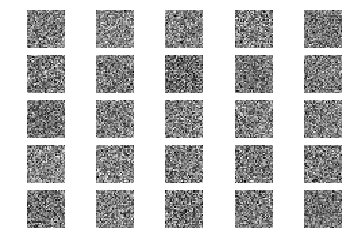

1 [D loss: 0.520652, acc.: 76.37%] [G loss: 0.765603]
2 [D loss: 0.416230, acc.: 75.59%] [G loss: 0.716062]
3 [D loss: 0.380220, acc.: 74.22%] [G loss: 0.717876]
4 [D loss: 0.381816, acc.: 73.05%] [G loss: 0.730561]
5 [D loss: 0.358279, acc.: 78.71%] [G loss: 0.785794]
6 [D loss: 0.341986, acc.: 85.35%] [G loss: 0.862053]
7 [D loss: 0.301993, acc.: 93.95%] [G loss: 0.950114]
8 [D loss: 0.267037, acc.: 96.68%] [G loss: 1.047465]
9 [D loss: 0.245985, acc.: 98.05%] [G loss: 1.152447]
10 [D loss: 0.214140, acc.: 98.44%] [G loss: 1.290432]
11 [D loss: 0.199085, acc.: 99.41%] [G loss: 1.384370]
12 [D loss: 0.179581, acc.: 99.22%] [G loss: 1.493219]
13 [D loss: 0.158173, acc.: 99.61%] [G loss: 1.611705]
14 [D loss: 0.154045, acc.: 99.02%] [G loss: 1.693840]
15 [D loss: 0.133007, acc.: 99.61%] [G loss: 1.828896]
16 [D loss: 0.130459, acc.: 99.41%] [G loss: 1.953652]
17 [D loss: 0.115132, acc.: 99.61%] [G loss: 2.069986]
18 [D loss: 0.102123, acc.: 99.61%] [G loss: 2.166128]
19 [D loss: 0.09350

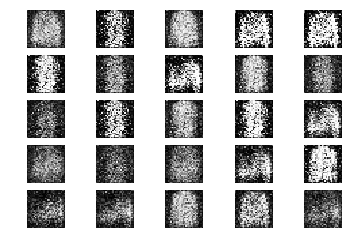

201 [D loss: 0.748434, acc.: 52.15%] [G loss: 1.159964]
202 [D loss: 0.686185, acc.: 53.52%] [G loss: 1.167178]
203 [D loss: 0.717428, acc.: 52.73%] [G loss: 1.231642]
204 [D loss: 0.794591, acc.: 46.88%] [G loss: 1.092572]
205 [D loss: 0.829962, acc.: 43.75%] [G loss: 0.995192]
206 [D loss: 0.783192, acc.: 48.44%] [G loss: 0.984006]
207 [D loss: 0.794599, acc.: 46.09%] [G loss: 0.939687]
208 [D loss: 0.716209, acc.: 52.15%] [G loss: 0.962743]
209 [D loss: 0.734160, acc.: 51.95%] [G loss: 0.999340]
210 [D loss: 0.734808, acc.: 51.17%] [G loss: 0.997140]
211 [D loss: 0.757641, acc.: 48.44%] [G loss: 1.025148]
212 [D loss: 0.784877, acc.: 43.75%] [G loss: 0.921021]
213 [D loss: 0.708380, acc.: 54.30%] [G loss: 0.948233]
214 [D loss: 0.736015, acc.: 51.95%] [G loss: 1.009648]
215 [D loss: 0.760907, acc.: 48.05%] [G loss: 0.933276]
216 [D loss: 0.734627, acc.: 48.83%] [G loss: 0.921862]
217 [D loss: 0.724430, acc.: 51.56%] [G loss: 0.909218]
218 [D loss: 0.739232, acc.: 47.85%] [G loss: 0.

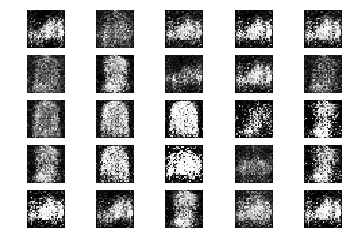

401 [D loss: 0.646887, acc.: 52.34%] [G loss: 0.829392]
402 [D loss: 0.649173, acc.: 54.88%] [G loss: 0.833161]
403 [D loss: 0.669434, acc.: 53.32%] [G loss: 0.822496]
404 [D loss: 0.655059, acc.: 55.08%] [G loss: 0.817396]
405 [D loss: 0.652194, acc.: 54.88%] [G loss: 0.816588]
406 [D loss: 0.647778, acc.: 50.78%] [G loss: 0.831467]
407 [D loss: 0.643836, acc.: 54.49%] [G loss: 0.837234]
408 [D loss: 0.635197, acc.: 56.25%] [G loss: 0.841925]
409 [D loss: 0.641797, acc.: 53.91%] [G loss: 0.851002]
410 [D loss: 0.659706, acc.: 51.37%] [G loss: 0.849118]
411 [D loss: 0.648789, acc.: 56.45%] [G loss: 0.856379]
412 [D loss: 0.667122, acc.: 50.78%] [G loss: 0.814313]
413 [D loss: 0.668473, acc.: 50.59%] [G loss: 0.827139]
414 [D loss: 0.663723, acc.: 51.95%] [G loss: 0.834236]
415 [D loss: 0.654214, acc.: 52.73%] [G loss: 0.821486]
416 [D loss: 0.667747, acc.: 51.17%] [G loss: 0.797069]
417 [D loss: 0.665967, acc.: 47.66%] [G loss: 0.787445]
418 [D loss: 0.675867, acc.: 48.83%] [G loss: 0.

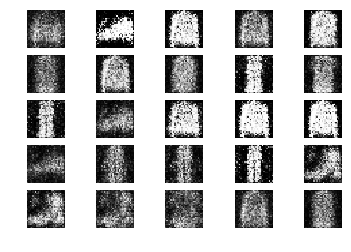

601 [D loss: 0.693159, acc.: 49.80%] [G loss: 0.797991]
602 [D loss: 0.687574, acc.: 50.59%] [G loss: 0.812282]
603 [D loss: 0.671065, acc.: 57.23%] [G loss: 0.806639]
604 [D loss: 0.682860, acc.: 55.27%] [G loss: 0.796382]
605 [D loss: 0.678065, acc.: 56.25%] [G loss: 0.792016]
606 [D loss: 0.691884, acc.: 51.95%] [G loss: 0.788583]
607 [D loss: 0.681799, acc.: 55.08%] [G loss: 0.779122]
608 [D loss: 0.679849, acc.: 51.37%] [G loss: 0.781070]
609 [D loss: 0.680434, acc.: 54.10%] [G loss: 0.795410]
610 [D loss: 0.665976, acc.: 57.42%] [G loss: 0.805485]
611 [D loss: 0.653556, acc.: 62.11%] [G loss: 0.804733]
612 [D loss: 0.685366, acc.: 51.17%] [G loss: 0.785902]
613 [D loss: 0.676098, acc.: 53.91%] [G loss: 0.788009]
614 [D loss: 0.651559, acc.: 61.33%] [G loss: 0.789857]
615 [D loss: 0.661691, acc.: 55.86%] [G loss: 0.770946]
616 [D loss: 0.672077, acc.: 54.69%] [G loss: 0.764987]
617 [D loss: 0.662367, acc.: 57.23%] [G loss: 0.767260]
618 [D loss: 0.665966, acc.: 54.30%] [G loss: 0.

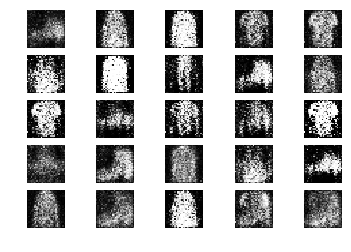

801 [D loss: 0.638900, acc.: 59.57%] [G loss: 0.821666]
802 [D loss: 0.645949, acc.: 59.38%] [G loss: 0.832528]
803 [D loss: 0.644344, acc.: 57.81%] [G loss: 0.827024]
804 [D loss: 0.637227, acc.: 60.35%] [G loss: 0.829523]
805 [D loss: 0.621027, acc.: 61.91%] [G loss: 0.845456]
806 [D loss: 0.634066, acc.: 60.94%] [G loss: 0.842059]
807 [D loss: 0.637028, acc.: 58.01%] [G loss: 0.862504]
808 [D loss: 0.638598, acc.: 61.13%] [G loss: 0.857857]
809 [D loss: 0.639736, acc.: 60.35%] [G loss: 0.862673]
810 [D loss: 0.612082, acc.: 67.97%] [G loss: 0.890020]
811 [D loss: 0.639150, acc.: 64.65%] [G loss: 0.884193]
812 [D loss: 0.611801, acc.: 69.73%] [G loss: 0.905884]
813 [D loss: 0.627665, acc.: 62.89%] [G loss: 0.888884]
814 [D loss: 0.636873, acc.: 63.28%] [G loss: 0.870341]
815 [D loss: 0.635051, acc.: 60.94%] [G loss: 0.880405]
816 [D loss: 0.622297, acc.: 64.26%] [G loss: 0.873671]
817 [D loss: 0.625339, acc.: 63.87%] [G loss: 0.891987]
818 [D loss: 0.646510, acc.: 61.91%] [G loss: 0.

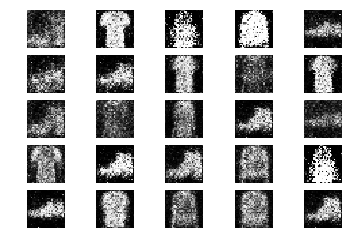

1001 [D loss: 0.625159, acc.: 62.30%] [G loss: 0.853539]
1002 [D loss: 0.617403, acc.: 65.43%] [G loss: 0.852147]
1003 [D loss: 0.618626, acc.: 65.43%] [G loss: 0.836711]
1004 [D loss: 0.616749, acc.: 64.45%] [G loss: 0.851960]
1005 [D loss: 0.608074, acc.: 66.60%] [G loss: 0.828808]
1006 [D loss: 0.608398, acc.: 62.50%] [G loss: 0.859423]
1007 [D loss: 0.621373, acc.: 63.67%] [G loss: 0.854803]
1008 [D loss: 0.615935, acc.: 66.21%] [G loss: 0.882081]
1009 [D loss: 0.631543, acc.: 58.79%] [G loss: 0.873289]
1010 [D loss: 0.642897, acc.: 58.98%] [G loss: 0.861083]
1011 [D loss: 0.606398, acc.: 65.82%] [G loss: 0.869510]
1012 [D loss: 0.626801, acc.: 62.11%] [G loss: 0.875081]
1013 [D loss: 0.627799, acc.: 63.28%] [G loss: 0.881238]
1014 [D loss: 0.627550, acc.: 61.72%] [G loss: 0.859722]
1015 [D loss: 0.607870, acc.: 65.04%] [G loss: 0.864406]
1016 [D loss: 0.626076, acc.: 61.13%] [G loss: 0.869380]
1017 [D loss: 0.601651, acc.: 66.99%] [G loss: 0.894309]
1018 [D loss: 0.640100, acc.: 6

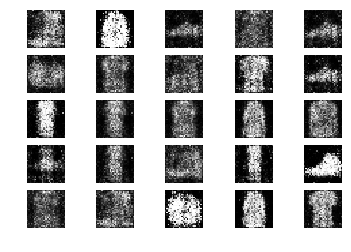

1201 [D loss: 0.640193, acc.: 61.91%] [G loss: 0.852227]
1202 [D loss: 0.620188, acc.: 66.02%] [G loss: 0.855986]
1203 [D loss: 0.606073, acc.: 68.95%] [G loss: 0.861819]
1204 [D loss: 0.616395, acc.: 67.77%] [G loss: 0.840312]
1205 [D loss: 0.630104, acc.: 63.28%] [G loss: 0.862871]
1206 [D loss: 0.622122, acc.: 65.43%] [G loss: 0.856821]
1207 [D loss: 0.631476, acc.: 63.28%] [G loss: 0.849722]
1208 [D loss: 0.596642, acc.: 70.31%] [G loss: 0.854690]
1209 [D loss: 0.615555, acc.: 67.19%] [G loss: 0.866342]
1210 [D loss: 0.617911, acc.: 63.48%] [G loss: 0.862108]
1211 [D loss: 0.595407, acc.: 68.36%] [G loss: 0.884122]
1212 [D loss: 0.635663, acc.: 64.26%] [G loss: 0.873951]
1213 [D loss: 0.621176, acc.: 66.02%] [G loss: 0.857209]
1214 [D loss: 0.602795, acc.: 67.77%] [G loss: 0.855230]
1215 [D loss: 0.628983, acc.: 61.72%] [G loss: 0.873700]
1216 [D loss: 0.621979, acc.: 60.55%] [G loss: 0.865225]
1217 [D loss: 0.637427, acc.: 58.01%] [G loss: 0.850816]
1218 [D loss: 0.634223, acc.: 5

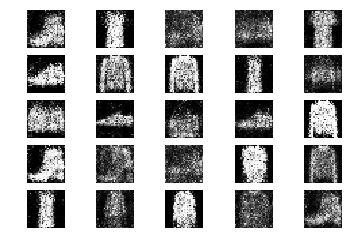

1401 [D loss: 0.637309, acc.: 64.26%] [G loss: 0.853507]
1402 [D loss: 0.638610, acc.: 62.89%] [G loss: 0.819443]
1403 [D loss: 0.649597, acc.: 62.50%] [G loss: 0.812599]
1404 [D loss: 0.625216, acc.: 65.82%] [G loss: 0.822945]
1405 [D loss: 0.643801, acc.: 58.01%] [G loss: 0.831295]
1406 [D loss: 0.642839, acc.: 59.18%] [G loss: 0.824204]
1407 [D loss: 0.653986, acc.: 58.98%] [G loss: 0.792377]
1408 [D loss: 0.628040, acc.: 65.23%] [G loss: 0.815919]
1409 [D loss: 0.640809, acc.: 58.98%] [G loss: 0.805417]
1410 [D loss: 0.669225, acc.: 55.66%] [G loss: 0.802360]
1411 [D loss: 0.649571, acc.: 58.59%] [G loss: 0.811682]
1412 [D loss: 0.664895, acc.: 58.59%] [G loss: 0.811183]
1413 [D loss: 0.665991, acc.: 58.01%] [G loss: 0.800973]
1414 [D loss: 0.658395, acc.: 60.16%] [G loss: 0.814699]
1415 [D loss: 0.660716, acc.: 57.23%] [G loss: 0.811521]
1416 [D loss: 0.687877, acc.: 53.52%] [G loss: 0.821420]
1417 [D loss: 0.649087, acc.: 59.38%] [G loss: 0.836703]
1418 [D loss: 0.659279, acc.: 5

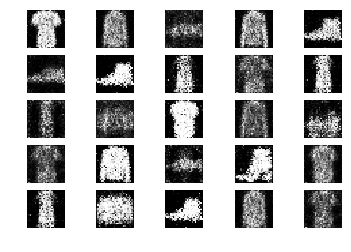

1601 [D loss: 0.648659, acc.: 57.62%] [G loss: 0.854409]
1602 [D loss: 0.654264, acc.: 59.18%] [G loss: 0.857255]
1603 [D loss: 0.637799, acc.: 63.67%] [G loss: 0.860956]
1604 [D loss: 0.668156, acc.: 55.08%] [G loss: 0.849230]
1605 [D loss: 0.630929, acc.: 61.52%] [G loss: 0.860360]
1606 [D loss: 0.651962, acc.: 56.45%] [G loss: 0.846057]
1607 [D loss: 0.642183, acc.: 59.18%] [G loss: 0.840579]
1608 [D loss: 0.658505, acc.: 56.25%] [G loss: 0.861751]
1609 [D loss: 0.642109, acc.: 63.48%] [G loss: 0.869242]
1610 [D loss: 0.653477, acc.: 58.20%] [G loss: 0.862841]
1611 [D loss: 0.659035, acc.: 58.59%] [G loss: 0.856587]
1612 [D loss: 0.658029, acc.: 58.01%] [G loss: 0.837802]
1613 [D loss: 0.640609, acc.: 65.62%] [G loss: 0.856904]
1614 [D loss: 0.642333, acc.: 63.87%] [G loss: 0.831664]
1615 [D loss: 0.650467, acc.: 60.35%] [G loss: 0.828057]
1616 [D loss: 0.628864, acc.: 66.80%] [G loss: 0.847275]
1617 [D loss: 0.630060, acc.: 64.45%] [G loss: 0.840220]
1618 [D loss: 0.647523, acc.: 6

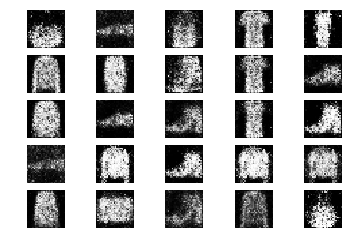

1801 [D loss: 0.654312, acc.: 56.25%] [G loss: 0.833794]
1802 [D loss: 0.645304, acc.: 59.57%] [G loss: 0.855578]
1803 [D loss: 0.641028, acc.: 60.16%] [G loss: 0.858458]
1804 [D loss: 0.640691, acc.: 61.91%] [G loss: 0.860598]
1805 [D loss: 0.664170, acc.: 56.05%] [G loss: 0.835615]
1806 [D loss: 0.656060, acc.: 58.79%] [G loss: 0.831579]
1807 [D loss: 0.640785, acc.: 60.74%] [G loss: 0.845422]
1808 [D loss: 0.669092, acc.: 57.03%] [G loss: 0.798195]
1809 [D loss: 0.657411, acc.: 59.96%] [G loss: 0.839009]
1810 [D loss: 0.657116, acc.: 65.23%] [G loss: 0.846695]
1811 [D loss: 0.649421, acc.: 60.55%] [G loss: 0.840388]
1812 [D loss: 0.650613, acc.: 63.48%] [G loss: 0.835785]
1813 [D loss: 0.649968, acc.: 62.11%] [G loss: 0.831831]
1814 [D loss: 0.655042, acc.: 61.52%] [G loss: 0.832781]
1815 [D loss: 0.648932, acc.: 62.70%] [G loss: 0.845053]
1816 [D loss: 0.664446, acc.: 57.81%] [G loss: 0.830108]
1817 [D loss: 0.664880, acc.: 57.42%] [G loss: 0.831511]
1818 [D loss: 0.675085, acc.: 5

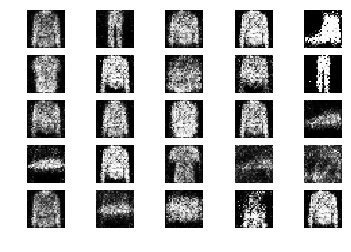

2001 [D loss: 0.646896, acc.: 61.72%] [G loss: 0.820735]
2002 [D loss: 0.660151, acc.: 60.94%] [G loss: 0.815403]
2003 [D loss: 0.644808, acc.: 58.40%] [G loss: 0.832750]
2004 [D loss: 0.631935, acc.: 66.60%] [G loss: 0.825643]
2005 [D loss: 0.647707, acc.: 60.16%] [G loss: 0.844632]
2006 [D loss: 0.656212, acc.: 58.01%] [G loss: 0.844252]
2007 [D loss: 0.664121, acc.: 57.42%] [G loss: 0.868216]
2008 [D loss: 0.655978, acc.: 60.16%] [G loss: 0.855316]
2009 [D loss: 0.643775, acc.: 61.72%] [G loss: 0.815519]
2010 [D loss: 0.658174, acc.: 59.77%] [G loss: 0.834474]
2011 [D loss: 0.660049, acc.: 55.47%] [G loss: 0.851821]
2012 [D loss: 0.663401, acc.: 58.98%] [G loss: 0.860800]
2013 [D loss: 0.664765, acc.: 58.59%] [G loss: 0.858048]
2014 [D loss: 0.672624, acc.: 60.16%] [G loss: 0.854326]
2015 [D loss: 0.662653, acc.: 57.42%] [G loss: 0.850444]
2016 [D loss: 0.650674, acc.: 63.67%] [G loss: 0.836165]
2017 [D loss: 0.653149, acc.: 62.50%] [G loss: 0.816731]
2018 [D loss: 0.656584, acc.: 5

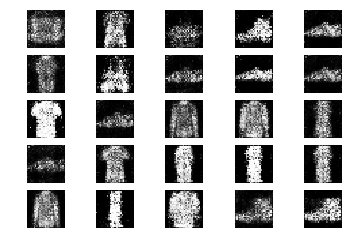

2201 [D loss: 0.687482, acc.: 52.93%] [G loss: 0.820033]
2202 [D loss: 0.679942, acc.: 52.73%] [G loss: 0.808495]
2203 [D loss: 0.674596, acc.: 54.30%] [G loss: 0.818430]
2204 [D loss: 0.667401, acc.: 55.47%] [G loss: 0.812219]
2205 [D loss: 0.666347, acc.: 56.05%] [G loss: 0.814471]
2206 [D loss: 0.673403, acc.: 56.84%] [G loss: 0.799528]
2207 [D loss: 0.668019, acc.: 55.27%] [G loss: 0.813833]
2208 [D loss: 0.673961, acc.: 56.64%] [G loss: 0.830600]
2209 [D loss: 0.662914, acc.: 55.47%] [G loss: 0.805827]
2210 [D loss: 0.649076, acc.: 63.09%] [G loss: 0.832393]
2211 [D loss: 0.657407, acc.: 59.38%] [G loss: 0.828575]
2212 [D loss: 0.662790, acc.: 57.03%] [G loss: 0.816541]
2213 [D loss: 0.660323, acc.: 60.74%] [G loss: 0.824578]
2214 [D loss: 0.657945, acc.: 60.74%] [G loss: 0.834369]
2215 [D loss: 0.680287, acc.: 54.49%] [G loss: 0.838714]
2216 [D loss: 0.653871, acc.: 64.06%] [G loss: 0.849656]
2217 [D loss: 0.649059, acc.: 63.28%] [G loss: 0.838576]
2218 [D loss: 0.640250, acc.: 6

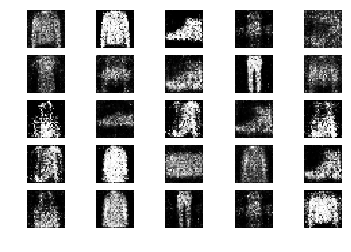

2401 [D loss: 0.658944, acc.: 59.96%] [G loss: 0.834295]
2402 [D loss: 0.657875, acc.: 58.79%] [G loss: 0.825830]
2403 [D loss: 0.667433, acc.: 58.59%] [G loss: 0.833153]
2404 [D loss: 0.651054, acc.: 59.77%] [G loss: 0.824552]
2405 [D loss: 0.664734, acc.: 59.57%] [G loss: 0.826795]
2406 [D loss: 0.638790, acc.: 64.84%] [G loss: 0.850089]
2407 [D loss: 0.674811, acc.: 56.45%] [G loss: 0.845077]
2408 [D loss: 0.653993, acc.: 61.52%] [G loss: 0.842002]
2409 [D loss: 0.654485, acc.: 59.57%] [G loss: 0.851806]
2410 [D loss: 0.666380, acc.: 58.59%] [G loss: 0.827934]
2411 [D loss: 0.668420, acc.: 59.57%] [G loss: 0.855793]
2412 [D loss: 0.649580, acc.: 61.13%] [G loss: 0.860422]
2413 [D loss: 0.656870, acc.: 61.52%] [G loss: 0.849257]
2414 [D loss: 0.666386, acc.: 62.11%] [G loss: 0.826982]
2415 [D loss: 0.647555, acc.: 63.48%] [G loss: 0.821647]
2416 [D loss: 0.653643, acc.: 62.11%] [G loss: 0.822240]
2417 [D loss: 0.666019, acc.: 58.20%] [G loss: 0.834293]
2418 [D loss: 0.668504, acc.: 5

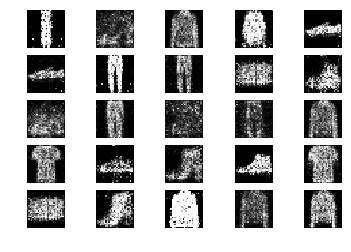

2601 [D loss: 0.646223, acc.: 59.96%] [G loss: 0.842043]
2602 [D loss: 0.655753, acc.: 59.96%] [G loss: 0.832078]
2603 [D loss: 0.679381, acc.: 53.32%] [G loss: 0.843123]
2604 [D loss: 0.670290, acc.: 60.16%] [G loss: 0.853135]
2605 [D loss: 0.678234, acc.: 56.84%] [G loss: 0.869214]
2606 [D loss: 0.644866, acc.: 61.91%] [G loss: 0.845257]
2607 [D loss: 0.662659, acc.: 58.98%] [G loss: 0.833852]
2608 [D loss: 0.663318, acc.: 57.81%] [G loss: 0.837142]
2609 [D loss: 0.666203, acc.: 56.05%] [G loss: 0.834873]
2610 [D loss: 0.663946, acc.: 60.35%] [G loss: 0.844661]
2611 [D loss: 0.667635, acc.: 58.59%] [G loss: 0.842328]
2612 [D loss: 0.674696, acc.: 56.84%] [G loss: 0.830240]
2613 [D loss: 0.666009, acc.: 57.23%] [G loss: 0.828865]
2614 [D loss: 0.667037, acc.: 59.18%] [G loss: 0.810503]
2615 [D loss: 0.662195, acc.: 56.25%] [G loss: 0.818934]
2616 [D loss: 0.655049, acc.: 57.81%] [G loss: 0.848209]
2617 [D loss: 0.683760, acc.: 53.12%] [G loss: 0.854796]
2618 [D loss: 0.657202, acc.: 6

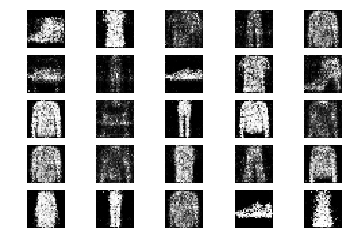

2801 [D loss: 0.666174, acc.: 57.81%] [G loss: 0.822730]
2802 [D loss: 0.663570, acc.: 58.40%] [G loss: 0.835171]
2803 [D loss: 0.664531, acc.: 55.86%] [G loss: 0.832231]
2804 [D loss: 0.672576, acc.: 54.10%] [G loss: 0.831298]
2805 [D loss: 0.667423, acc.: 57.42%] [G loss: 0.842377]
2806 [D loss: 0.677322, acc.: 56.45%] [G loss: 0.841574]
2807 [D loss: 0.665800, acc.: 59.18%] [G loss: 0.836716]
2808 [D loss: 0.676550, acc.: 53.71%] [G loss: 0.835459]
2809 [D loss: 0.665125, acc.: 60.55%] [G loss: 0.842435]
2810 [D loss: 0.649770, acc.: 59.96%] [G loss: 0.843982]
2811 [D loss: 0.652448, acc.: 58.40%] [G loss: 0.840232]
2812 [D loss: 0.664457, acc.: 58.59%] [G loss: 0.825332]
2813 [D loss: 0.666613, acc.: 56.64%] [G loss: 0.825402]
2814 [D loss: 0.653543, acc.: 62.70%] [G loss: 0.830839]
2815 [D loss: 0.665471, acc.: 55.86%] [G loss: 0.838256]
2816 [D loss: 0.672353, acc.: 56.64%] [G loss: 0.825818]
2817 [D loss: 0.646850, acc.: 62.89%] [G loss: 0.826908]
2818 [D loss: 0.671304, acc.: 5

In [12]:
GAN_object = GAN()
train(GAN_object, epochs = 3000, batch_size = 256, sample_interval = 200)